In [2]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath


conn = sqlite3.connect(dbPath())
query_lsoa_codes = "SELECT geogcode FROM lsoa_code_to_name"
lsoa_codes = pd.read_sql(query_lsoa_codes, conn)

query_unemployement = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
unemployement = pd.read_sql(query_unemployement, conn)

unemployement.dropna(inplace=True)
unemployement.drop(columns="index", inplace=True)
unemployement = unemployement[(unemployement["date"]<"2020") & (unemployement["date"]>"2012")]

unemployement = unemployement[unemployement["geogcode"]!="Column Total"].copy()
lsoa_code_list = lsoa_codes[lsoa_codes["geogcode"] != "Column Total"]["geogcode"].to_list()
allFeatures = pd.DataFrame(columns=lsoa_code_list, index=unemployement["date"].unique())

for row in tqdm(unemployement.index):
    allFeatures[unemployement["geogcode"][row]][unemployement["date"][row]] = unemployement["value"][row]

for code in tqdm(lsoa_code_list):
    for i in range(12):
        allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)

allFeatures = allFeatures.dropna()

code_out_shift = allFeatures[lsoa_code_list].copy()
code_with_shift = allFeatures.drop(lsoa_code_list, axis=True).copy()

In [8]:
code_with_shift.head()

,E01000115_shift_1,E01000115_shift_2,E01000115_shift_3,E01000115_shift_4,E01000115_shift_5,E01000115_shift_6,E01000115_shift_7,E01000115_shift_8,E01000115_shift_9,E01000115_shift_10,...,E01033573_shift_3,E01033573_shift_4,E01033573_shift_5,E01033573_shift_6,E01033573_shift_7,E01033573_shift_8,E01033573_shift_9,E01033573_shift_10,E01033573_shift_11,E01033573_shift_12
2014-01-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,10.0,...,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0,25.0
2014-02-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,...,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0
2014-03-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,...,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0
2014-04-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,...,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0
2014-05-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,25.0,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0


In [5]:

modelDct = {}
metrics = {
}
for col in tqdm(lsoa_code_list):
    y = code_out_shift[col].copy()
    x = code_with_shift.copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model = xgb.XGBRegressor()
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    medae_test = median_absolute_error(y_test, y_pred)
    metrics[col] = [mse_test, mae_test, r2_test, medae_test]
    model.save_model( modelPath(col))

  0%|          | 0/211 [00:00<?, ?it/s]

In [6]:
X_train

,E01000115_shift_1,E01000115_shift_2,E01000115_shift_3,E01000115_shift_4,E01000115_shift_5,E01000115_shift_6,E01000115_shift_7,E01000115_shift_8,E01000115_shift_9,E01000115_shift_10,...,E01033573_shift_3,E01033573_shift_4,E01033573_shift_5,E01033573_shift_6,E01033573_shift_7,E01033573_shift_8,E01033573_shift_9,E01033573_shift_10,E01033573_shift_11,E01033573_shift_12
2015-12-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,15.0,15.0,...,25.0,25.0,25.0,20.0,15.0,15.0,10.0,10.0,15.0,20.0
2017-06-01 00:00:00,10.0,10.0,10.0,10.0,10.0,5.0,10.0,10.0,10.0,5.0,...,20.0,20.0,15.0,15.0,20.0,20.0,20.0,15.0,20.0,20.0
2019-12-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,5.0,5.0,...,35.0,40.0,40.0,40.0,40.0,30.0,30.0,30.0,35.0,35.0
2014-09-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,20.0,20.0,20.0,25.0,25.0,20.0,30.0,30.0,35.0,35.0
2014-04-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,...,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0
2014-02-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,...,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0
2018-05-01 00:00:00,5.0,5.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0,5.0,...,20.0,25.0,20.0,20.0,20.0,20.0,20.0,25.0,20.0,20.0
2018-11-01 00:00:00,5.0,10.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,25.0,25.0,15.0,15.0,15.0,15.0,20.0,25.0,20.0,20.0
2017-10-01 00:00:00,10.0,10.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0,5.0,...,25.0,20.0,20.0,20.0,20.0,20.0,15.0,15.0,20.0,20.0
2018-04-01 00:00:00,5.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0,5.0,5.0,...,25.0,20.0,20.0,20.0,20.0,20.0,25.0,20.0,20.0,20.0


In [119]:
fig, ax = plt.subplots()

ax.plot(y_train.index, y_train)
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, y_pred)


In [120]:
max_key = max(metrics, key=lambda k: metrics[k][0])

In [121]:
allFeatures.reset_index(inplace=True)
allFeatures = allFeatures.rename(columns={"index":"date"})

In [122]:
code_out_shift = allFeatures[lsoa_code_list].copy()
code_with_shift = allFeatures.drop(lsoa_code_list, axis=True).copy()

In [123]:
columns = ["target_value", "target_code"] + list(code_with_shift.columns)

ls = []
for code in tqdm(iter(code_out_shift.columns)):
    temp = code_with_shift.copy()
    temp["target_code"] = code
    temp["target_value"] = code_out_shift[code]
    temp.reset_index(inplace=True)
    ls.append(temp)

final = pd.concat(ls)
final = final.rename(columns={"index":"date"})
encoded_LSOA = pd.get_dummies(final["target_code"], prefix="is")
finalEncoded = pd.concat([final, encoded_LSOA], axis=1)

0it [00:00, ?it/s]

In [124]:
finalEncoded

,date,E01000115_shift_1,E01000115_shift_2,E01000115_shift_3,E01000115_shift_4,E01000115_shift_5,E01000115_shift_6,E01000115_shift_7,E01000115_shift_8,E01000115_shift_9,...,is_E01000317,is_E01000318,is_E01000319,is_E01000320,is_E01000321,is_E01000322,is_E01000323,is_E01000324,is_E01033572,is_E01033573
0,2014-01-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,...,0,0,0,0,0,0,0,0,0,0
1,2014-02-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,2014-03-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,...,0,0,0,0,0,0,0,0,0,0
3,2014-04-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4,2014-05-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01 00:00:00,10.0,10.0,10.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1
68,2019-09-01 00:00:00,10.0,10.0,10.0,10.0,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1
69,2019-10-01 00:00:00,10.0,10.0,10.0,10.0,10.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1
70,2019-11-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1


In [125]:
model = xgb.XGBRegressor()
x = finalEncoded.drop(columns = ["target_value", "target_code", "date"]).copy()
y = finalEncoded[["target_value", "target_code", "date"]].copy()


In [126]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = xgb.XGBRegressor()
model.fit(X_train.values, y_train["target_value"].values)

pred_train = model.predict(X_train.values)
predictions = model.predict(X_test.values)

mse_train = mean_squared_error(y_train["target_value"].values, pred_train)
mae_train = mean_absolute_error(y_train["target_value"].values, pred_train)
r2_train = r2_score(y_train["target_value"].values, pred_train)
medae_train = median_absolute_error(y_train["target_value"].values, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test["target_value"].values, predictions)
mae_test = mean_absolute_error(y_test["target_value"].values, predictions)
r2_test = r2_score(y_test["target_value"].values, predictions)
medae_test = median_absolute_error(y_test["target_value"].values, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

In [127]:
metricsDF = pd.DataFrame(metrics)
metricsDF

,Metric,Train Value,Test Value
0,MSE,15.709818,24.870228
1,MAE,3.094560,3.853036
2,R^2,0.893677,0.838387
3,MedAE,2.522923,3.170776


In [137]:
y_test = y_test.reset_index(drop=True)
# y_test = y_test.drop("index")
y_test

,index,target_value,target_code,date
0,59,20.0,E01000284,2018-12-01 00:00:00
1,25,35.0,E01000124,2016-02-01 00:00:00
2,5,5.0,E01000258,2014-06-01 00:00:00
3,48,25.0,E01000142,2018-01-01 00:00:00
4,37,10.0,E01000187,2017-02-01 00:00:00
...,...,...,...,...
3034,22,15.0,E01000215,2015-11-01 00:00:00
3035,26,40.0,E01000151,2016-03-01 00:00:00
3036,60,15.0,E01000180,2019-01-01 00:00:00
3037,22,5.0,E01000254,2015-11-01 00:00:00


In [138]:
preDF = pd.DataFrame({"Pred":predictions})
preDF

,Pred
0,18.136692
1,26.001656
2,13.339431
3,21.418447
4,13.583910
...,...
3034,15.894568
3035,38.403500
3036,20.197641
3037,7.325423


In [143]:

y_test = y_test.join(preDF)

In [144]:
for lsoa in lsoa_code_list:
    temp = y_test[y_test["target_code"] == lsoa]
    break
temp

,index,target_value,target_code,date,Pred
59,39,10.0,E01000115,2017-04-01 00:00:00,11.045834
363,48,5.0,E01000115,2018-01-01 00:00:00,11.725984
444,64,10.0,E01000115,2019-05-01 00:00:00,13.909559
943,59,5.0,E01000115,2018-12-01 00:00:00,10.586124
978,58,5.0,E01000115,2018-11-01 00:00:00,10.201917
1035,47,10.0,E01000115,2017-12-01 00:00:00,8.852693
1157,21,10.0,E01000115,2015-10-01 00:00:00,11.917974
1637,57,5.0,E01000115,2018-10-01 00:00:00,9.314771
2035,49,5.0,E01000115,2018-02-01 00:00:00,10.992709
2315,69,10.0,E01000115,2019-10-01 00:00:00,16.610867


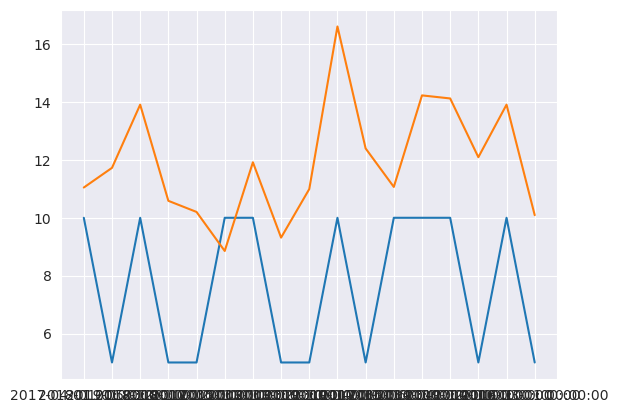

In [145]:
fig, ax = plt.subplots()
ax.plot(temp["date"], temp["target_value"])
ax.plot(temp["date"], temp["Pred"])

In [132]:
# by_metric = {'MSE':[], 'MAE':[], 'R^2':[], "MedAE":[]}
# for val in metrics.values():
#     by_metric["MSE"].append(val[0])
#     by_metric["MAE"].append(val[1])
#     by_metric["R^2"].append(val[2])
#     by_metric["MedAE"].append(val[3])

In [133]:
# import seaborn as sns


In [134]:
# metricDF = pd.DataFrame(by_metric)

In [135]:
# sns.violinplot(data=metricDF["R^2"])

In [136]:
# sns.violinplot(data=metricDF["MSE"])
